Miałem trochę przygody z ogarnianiem tensorflow na gpu, ponieważ korzystam z wsl2 z ArchLinux. Biblioteki cuda i cudnn są oficjalnie kompilowane na pochodne debiana i redhat, ale w repozytorium arch też są, tylko że w wersjach nowszych niż wskazuje wersja tensorflow, której chciałem użyć (2.18, obecnie najnowsza), a w repozytorium aur były wersje tylko starsze niż porządane, musiałem pobrać wersje na debiana z oficjalnej strony nvidii i cuda ręcznie instalować z pliku linux.run, a cudnn ręcznie przerzucać pliki do katalogów cuda. Jeszcze po drodze udało mi się pobierać nie te wersje, zastanawiać się jak do tego wszystkiego w ogóle dojść, a na koniec i tak nie działało i musiałem jeszcze instalować tensorflow na nowo z komendy pip install tensorflow['and-cuda'] zamiast samego pip install tensorflow, dopiero wtedy tf wykrył moje gpu.

Ale teraz mam już ustawione tensorflow pod gpu, za pana radą zrobiłem to ostatecznie w nowym środowisku wirtualnym pythona, a jeszcze do tego ustawiłem sobie połączenie z windowsowego vscode do zasobów wsl, więc mogę teraz z windowsa odpalać kod w linuxie, co upraszcza trochę proces. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna as op
import librosa
import opensmile as ops
import os
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder as le, StandardScaler as ss, FunctionTransformer as ft
from sklearn.feature_selection import SelectKBest as SKB, f_regression
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as pl
from sklearn.linear_model import Ridge

2024-12-09 01:04:56.975121: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 01:04:57.252591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733702697.363984     515 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733702697.393578     515 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 01:04:57.701122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


Poniższy kod na pliku ćwiczeniowym przedstawia wykresy zgodnie z zaleceniem Copilota, ale porównywanie przewidywanych do rzeczywistych w ten sposób brzmiało mi bardziej na macierz pomyłek niż odpowiednie przedstawienie modelu na wykresie... 

/SI/si/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733515285.887088 3194186 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:c4:00.0, compute capability: 8.9
I0000 00:00:1733515286.734008 3194353 service.cc:148] XLA service 0x7fd058017210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733515286.734193 3194353 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1733515286.750186 3194353 cuda_dnn.cc:529] Loaded cuDNN version 90500
I0000 00:00:1733515286.836074 3194

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


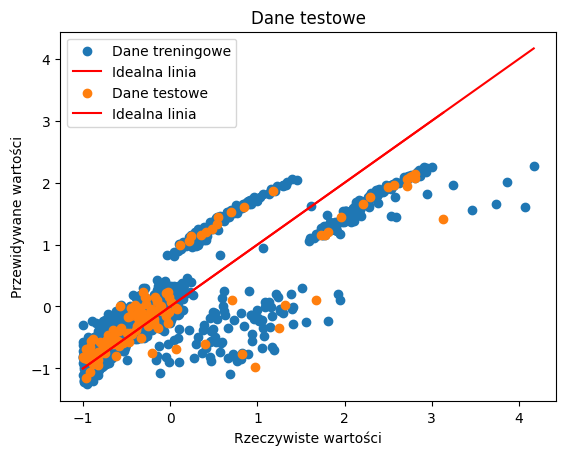

In [3]:
df = pd.read_csv("insurance.csv")
df.dropna(inplace=True)
for i in ['sex', 'smoker', 'region']:
    df[i]=le().fit_transform(df[i])
df_scaled = ss().fit_transform(df)
X = df_scaled[:,0:6]
y = df_scaled[:,6]

X_train, X_test, y_train, y_test = tts(X, y, train_size=0.9)

model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(6,))])


model.compile(optimizer='sgd', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, verbose=0)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test) 

plt.scatter(y_train, y_pred_train, label='Dane treningowe')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', label="Idealna linia")
plt.xlabel("Rzeczywiste wartości")
plt.ylabel("Przewidywane wartości")
plt.title("Dane treningowe")
plt.legend()

plt.scatter(y_test, y_pred_test, label="Dane testowe")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label="Idealna linia")
plt.xlabel("Rzeczywiste wartości")
plt.ylabel("Przewidywane wartości")
plt.title("Dane testowe")
plt.legend()

plt.show()

...stąd poniższy kod, na którym punkty przedstawiają rzeczywiste dane (aczkolwiek po pca, bo nie mogłem rozrzucić X_test po wykresie, gdy każdy wiersz ma 6 kolumn, 7-wymiarowej wizualizacji nie potrafię zrobić), a linia predykcje z modelu, co pokazuje jak model zinterpretował dane i jaką linię wyznaczył w ramach regresji, to pca wyjasnia tylko 20% danych niestety

/SI/si/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


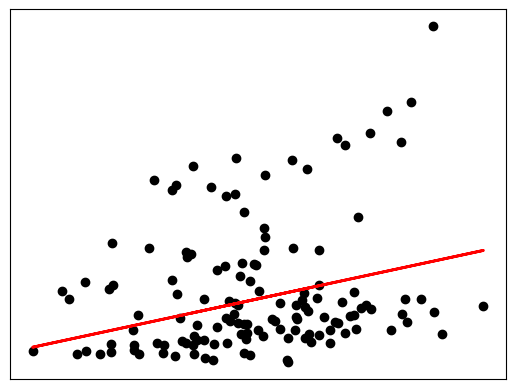

In [4]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = tts(X_pca, y, train_size=0.9)

model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])


model.compile(optimizer='sgd', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, verbose=0)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test) 

# Plot outputs
plt.scatter(X_test, y_test,  color='black') #plot scatters
plt.plot(X_test, y_pred_test, color='red', linewidth=2) #plot line

plt.xticks(())
plt.yticks(())

plt.show()

In [6]:
df = pd.read_csv("Real estate.csv")
columns_to_drop = ['No', 'X1 transaction date']
for i in columns_to_drop:
    df.drop(i, axis=1, inplace=True)
df_scaled = ss().fit_transform(df)
X = df_scaled[:,0:5]
y = df_scaled[:,5]

X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8, random_state=1)

model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(5,))])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='huber')

model.fit(X_train, y_train, epochs=200, verbose=0)

y_pred_test = model.predict(X_test)

print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred_test)}')
print(f'Max error: {max_error(y_test, y_pred_test)}')

/SI/si/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/stepWARNING:tensorflow:5 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fd15575c360> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Mean absolute error: 0.3779702928154668
Max error: 1.2477815708817979


Na początku uzyskiwałem większy błąd maksymalny, ale random_state=1 pozwala mi na uzyskanie o wiele niższego błędu maskymalnego (wcześniej było zawsze ponad 2, czasem nawet ponad 4)

Uważam, że można zoptymalizować model poprzez zmianę parametrów, najlepsze wyniki uzyskiwałem dla optymalizatorów sgd i rmsprop, adam i adagrad zapewniały wielokrotnie gorszy błąd maksymalny (powyżej 5), najpierw korzystałem z funkcji straty mean_squared_error, ale potem przerzuciłem się na huber i zapewnia ona lepsze wyniki, tutaj nawet rmsprop wychyla się przed sgd
Można również dostosować tempo uczenia, co wykonałem w powyższym kodzie. Można też zoptymalizować czas i skrócić czas uczenia poprzez funkcję EarlyStopping z tf.keras.callbacks, która umożliwia przerwanie treningu, gdy wydajność na zbiorze walidacyjnym przestaje się poprawiać. Nie wykorzystałem tego w kodzie, ponieważ i tak się szybko wykonuje.
Można jeszcze ustawić batch_size w model.fit, czyli rozmiar partii treningowej na jedną iterację, oraz epochs, czyli ile razy cały zbiór treningowy zostanie przetworzony przez model (można wywołać przetrenowanie zbyt dużą wartością).
Epochs najpierw ustawiałem na 100, potem na 500, ale w przypadku tych danych nie było dużych różnic, więc ostatecznie postawiłem na 200.

Zadanie 2

Wczytanie plików audio i obliczenie i ch częstotliwości tonu podstawowego

In [7]:
wavs = []
for root, dirs, files in os.walk("ND/"):
    for file in files:
        if file.endswith('.wav'):
            wavs.append(os.path.join(root, file))
audios = []
srs = []
for wav in wavs:
    audio, sr = librosa.load(wav)
    audios.append(audio)
    srs.append(sr)
f0s = []
for audio in audios:
    f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa. note_to_hz('C7'))
    f0s.append(f0)

Macierz cech

In [8]:
smile = ops.Smile(
    feature_set=ops.FeatureSet.ComParE_2016,
    feature_level=ops.FeatureLevel.Functionals
)
feats = pd.DataFrame(columns=smile.process_signal(audio, sr).columns)
for audio, sr in zip(audios, srs):
    feats = pd.concat([feats, smile.process_signal(audio, sr)])

/tmp/ipykernel_3194186/1354539620.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feats = pd.concat([feats, smile.process_signal(audio, sr)])


Ograniczenie cech do 100 i skalowanie

Po późniejszym wykonaniu optuny na parametr k, zwiększyłem go do 500, a epochs poniżej z 200 do 400, MAE spadło z 27 do 18, a MSE z kilku tysięcy do 726.

In [9]:
f0s_m = [np.nanmedian(f) if not np.isnan(f).all() else np.nan for f in f0s]
feats_reduced = SKB(score_func=f_regression, k=100).fit_transform(feats.values, f0s_m)
feats_r_scaled = ss().fit_transform(feats_reduced)

Trenowanie na sklearn, które dodałem właściwie na samym końcu zadania, bo po pierwsze czemu nie, a po drugie nie chciało mi się jeszcze tworzyć pipeline na tf do tak prostego zadania (aczkolwiek przejrzałem sobie dwie metody, pierwsza na sklearnowym pipeline, gdzie tworzy się klasę z metodami taką, aby sklearn pipeline mógł ją obsłużyć, a w metodach wrzuca się tf; a druga metoda polegała na wykorzystaniu tfx, tylko wtedy podobno musiałbym model tworzyć w osobnym pliki i przekazywać przez argumenty, aczkolwiek możliwości składni są interesujące i na pewno w przyszłości wyokrzystam w jakimś zadaniu), pod sklearn jest dużo prościej.

In [10]:
X_train, X_test, y_train, y_test = tts(feats_r_scaled, np.array(f0s_m), train_size=0.8)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Max error: {max_error(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')

Mean absolute error: 31.868006579050352
Max error: 688.9084883665996
Mean squared error: 3091.224156036088


In [21]:
X_train, X_test, y_train, y_test = tts(feats_r_scaled, np.array(f0s_m), train_size=0.8)

pipe = pl([
    
    ('feature_selection', SKB(score_func=f_regression, k=100)),
    ('scaler', ss()),
    ('ridge', Ridge(alpha=1.0))
])

pipe.fit(feats_r_scaled, np.array(f0s_m))

y_pred = pipe.predict(X_test)

print(f'Pipeline score: {pipe.score(X_test, y_test)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Max error: {max_error(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')

Pipeline score: 0.8971993339752706
Mean absolute error: 28.91301640480324
Max error: 142.71242958068615
Mean squared error: 1387.201454173757


Od ręki dostałem dobre wyniki, bardzo zbliżone do ostatecznych z tf, co pokazuje jak dobre jest sklearn dla początkujących. Aktualizacja: Przecież korzysta z moich ostatnich zmian, czyli k=500 zamiast 100... Po zmianie na k=100 wykonuje się 0.0s (w porównaniu do 45-60s w tf), a wyniki są nadal podobne. Co też pociesza mnie, że algorytm w tf jest napisany poprawnie.

Następnie próbowałem również dodać tts do pipe'a, ale nie odniosłem na tym polu sukcesów, ponieważ nie byłem pewien, jak następnie przekazać dane z wewnętrznego tts do Ridge.

Podział danych, szkolenie modelu przypominającego ridge regression na tf

In [192]:
X_train, X_test, y_train, y_test = tts(feats_r_scaled, np.array(f0s_m), train_size=0.8)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(500,)))
model.add(tf.keras.layers.Dense(1,  kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss='huber') 
model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test), verbose=0)

y_pred_test = model.predict(X_test) 

print(f'Loss: {model.evaluate(X_test, y_test)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred_test)}')
print(f'Max error: {max_error(y_test, y_pred_test)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred_test)}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.4547 
Loss: 20.178421020507812
Mean absolute error: 18.54263496687731
Max error: 237.52588378414714
Mean squared error: 726.907663094208


Optuna dla parametrów
Najpierw wykonałem MAE, potem max_error, porównując oba stwierdziłem, że minimalizacja max_error jest bardziej dokładna, ponieważ dokładnych wyników może mocno zmniejszyć błąd średni, ale zmniejszenie błędu maksymalnego zdaje się wpływać mocniej na dokładność zbioru. Z drugiej strony może być tylko jeden bardzo odchylony wynik, który spowoduje taki błąd maksymalny, ale ogólnie reszta wyników będzie względnie w porządku. Tak na prawdę to trzeba by sprawdzić statystyki tych wyników, jak wiele obiektów miało duże odchylenie od średniej, jak wiele miało małe, itd.
Następnie wykonałem MSE, bo zauważyłem, że porównywać mieliśmy z tym. Przez kwadratowość, na MSE dużo większy wpłw mają duże błędy, bo z kwadratem będą wykładniczo większe, za to MAE przedstawia bardziej zrównoważony wynik, na który wartości graniczne nie mają aż takiego wpływu. 
W moim przypadku dla obu testów optuna dostałem takie same wyniki parametrów

In [187]:
X_train, X_test, y_train, y_test = tts(feats_r_scaled, np.array(f0s_m), train_size=0.8)

def objective(trial):
    den = trial.suggest_categorical('den', [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
    l_r = trial.suggest_categorical('l_r', [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(100,)))
    model.add(tf.keras.layers.Dense(1,  kernel_regularizer=tf.keras.regularizers.l2(den)))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=l_r), loss='huber')
    model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), verbose=0)

    y_pred_test = model.predict(X_test) 

    score = mean_squared_error(y_test, y_pred_test)

    return score

study = op.create_study(direction='minimize')

study.optimize(objective, n_trials=36)
clear_output()
print(f'Najlepsze hiperparametry: {study.best_params}')
print(f'Najlepszy wynik dokładności: {study.best_value}')

Najlepsze hiperparametry: {'den': 0.0001, 'l_r': 0.1}
Najlepszy wynik dokładności: 3102.600520950418


Optuna dla SKB, otrzymany wynik to 500, co jest właściwie spodziewane, im więcej cech tym lepiej opisane, nawet jeśli różnica minimalna.

In [ ]:
def objective(trial):
    kk = trial.suggest_int("k", 50, 510, 50)

    f0s_m = [np.nanmedian(f) if not np.isnan(f).all() else np.nan for f in f0s]
    feats_reduced = SKB(score_func=f_regression, k=kk).fit_transform(feats.values, f0s_m)
    feats_r_scaled = ss().fit_transform(feats_reduced)

    X_train, X_test, y_train, y_test = tts(feats_r_scaled, np.array(f0s_m), train_size=0.8, random_state=1)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(kk,)))
    model.add(tf.keras.layers.Dense(1,  kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss='huber')
    model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), verbose=0)

    y_pred_test = model.predict(X_test) 

    score = mean_absolute_error(y_test, y_pred_test)

    return score

study = op.create_study(direction='minimize')

study.optimize(objective, n_trials=10)
clear_output()
print(f'Najlepsze hiperparametry: {study.best_params}')
print(f'Najlepszy wynik dokładności: {study.best_value}')

Najlepsze hiperparametry: {'k': 500}
Najlepszy wynik dokładności: 21.533736357145


Podział danych, szkolenie modelu sieci z dwoma warstwami ukrytymi

In [ ]:
X_train, X_test, y_train, y_test = tts(feats_r_scaled, np.array(f0s_m), train_size=0.8)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(500,)))
model.add(tf.keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(tf.keras.layers.Dense(32, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss='huber')
model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test), verbose=0)

y_pred_test = model.predict(X_test) 

print(f'Loss: {model.evaluate(X_test, y_test)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred_test)}')
print(f'Max error: {max_error(y_test, y_pred_test)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred_test)}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.2235 
Loss: 20.561819076538086
Mean absolute error: 20.0922257390604
Max error: 568.7818404173809
